In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# Data augmentation

In [44]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [46]:
os.chdir('/Documents/data/flower-photos/')

dirs = os.listdir()

for dir in dirs:
    images = os.listdir(dir)
    for image in images:
        image_path = '/Documents/data/flower-photos/'+dir+'/'+image
        # Obtain image by reading the image from disk
        image = np.expand_dims(plt.imread(image_path),0)
        # Generate and save batches of augmented images from the original image
        aug_iter = gen.flow(image, save_to_dir='/Documents/data/flower-photos/'+dir, save_prefix='aug-', save_format='jpeg')
        aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
        
    print(dir)

daisy
dandelion
roses
sunflowers
tulips


# Image preparation

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
# Organize data into train, valid, test dirs
os.chdir('/Documents/data/flower-photos')

dirs = os.listdir()

if os.path.isdir('train/daisy/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for dir in dirs:
        if dir != 'train' and dir != 'test' and dir != 'valid':
            shutil.move(dir, 'train')
            os.mkdir(f'valid/{dir}')
            os.mkdir(f'test/{dir}')
              
            valid_samples = random.sample(os.listdir(f'train/{dir}'), 500)
            for j in valid_samples:
                shutil.move(f'train/{dir}/{j}', f'valid/{dir}')

            test_samples = random.sample(os.listdir(f'train/{dir}'), 150)
            for k in test_samples:
                shutil.move(f'train/{dir}/{k}', f'test/{dir}')
os.chdir('../..')

In [49]:
os.chdir('/Documents/')

train_path = 'data/flower-photos/train'
valid_path = 'data/flower-photos/valid'
test_path = 'data/flower-photos/test'

In [50]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=75)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 26345 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 750 images belonging to 5 classes.


# Modify model

In [51]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [52]:
x = mobile.layers[-6].output
output = Dense(units=5, activation='softmax')(x)

In [53]:
model = Model(inputs=mobile.input, outputs=output)

In [54]:
for layer in model.layers[:-28]:
    layer.trainable = False

In [55]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

# Train model

In [56]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [57]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
352/352 - 289s - loss: 0.1808 - accuracy: 0.9419 - val_loss: 0.0337 - val_accuracy: 0.9940
Epoch 2/30
352/352 - 108s - loss: 0.0170 - accuracy: 0.9986 - val_loss: 0.0230 - val_accuracy: 0.9948
Epoch 3/30
352/352 - 104s - loss: 0.0064 - accuracy: 0.9997 - val_loss: 0.0074 - val_accuracy: 0.9992
Epoch 4/30
352/352 - 94s - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 5/30
352/352 - 94s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9988
Epoch 6/30
352/352 - 93s - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 7/30
352/352 - 114s - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 8/30
352/352 - 124s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 9/30
352/352 - 115s - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 0.9992
Epoch 10/30
352/352 - 119s - loss: 6.2591e-04 - accuracy: 0.9999 - val_loss: 6.8087e-

# Prediction

In [58]:
test_labels = test_batches.classes

In [59]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [60]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [61]:
test_batches.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Confusion matrix, without normalization
[[150   0   0   0   0]
 [  0 150   0   0   0]
 [  0   0 150   0   0]
 [  0   0   0 150   0]
 [  0   0   0   0 150]]


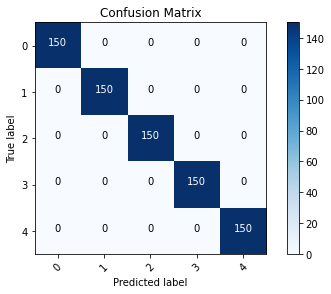

In [62]:
cm_plot_labels = ['0','1','2','3','4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [63]:
model.save('models/myFlower_model.h5')